In [52]:
import os
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt



In [53]:
# Function to perform grid search for ARIMA
def grid_search_arima(data, p_range, d_range, q_range):
    stock_prices = data['close'].values
    time_series = pd.Series(stock_prices)
    train_data = time_series[1:len(time_series)-200]
    test_data = time_series[len(time_series)-200:]

    p_values = [0, 1, 2, 3, 5, 7]
    d_values = range(0, 3)
    q_values = range(0, 3)
    min_error = 1000000000
    best_order = ()

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                warnings.filterwarnings("ignore")
                try:
                    model = ARIMA(train_data, order=order).fit()
                    predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
                    error = mean_squared_error(test_data, predictions)

                    if error < min_error:
                        min_error = error
                        best_order = order
                except:
                    continue

    return best_order


In [54]:
# ARIMA predictor function
def predictor_arima(df, initial_capital=10000):
    df.dropna(inplace=True)
    
    # Power transformation (box-cox) to stabilize variance
    boxcox = PowerTransformer(method="box-cox")
    xtrain = boxcox.fit_transform(np.array(df['close']).reshape(-1, 1))
    
    # Using ARIMA with the best order
    best_order = grid_search_arima(df, p_range=[0,1,2,3,5,7], d_range=[0,1,2], q_range=[0,1,2])
    model = ARIMA(xtrain, order=best_order)
    model_fit = model.fit()

    # Predicting next 100 values
    next_100 = model_fit.forecast(100)

    # Inverse box-cox transform to return to original scale
    y_pred = list(boxcox.inverse_transform(np.array(next_100).reshape(-1, 1)))
    
    ids = [f"pred_#{i}" for i in range(1, 101)]
    pred_df = pd.DataFrame({'ID': ids, 'Price': [i[0] for i in y_pred]})
    
    return pred_df

Total Strategy Return (from $10,000): $29338.84
Total Market Return (from $10,000): $21686.02
Win Percentage: 50.83%
Average Return per Trade: 0.0040%
Maximum Drawdown: -81.58%


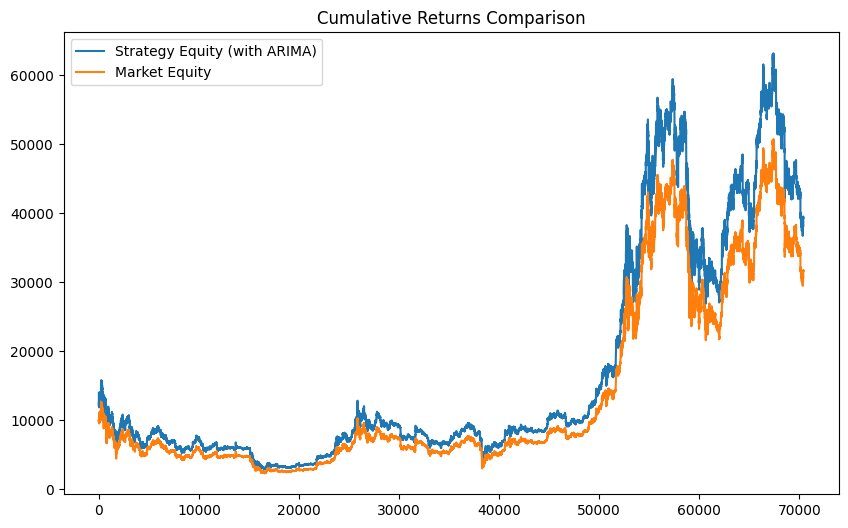

In [55]:
# Backtesting function
def backtest_strategy(df, initial_capital=10000):
    df.dropna(inplace=True)

    # Calculate market returns
    df['Market_Returns'] = df['close'].pct_change()

    # Power transformation for ARIMA input
    boxcox = PowerTransformer(method="box-cox")
    xtrain = boxcox.fit_transform(np.array(df['close']).reshape(-1, 1))

    # Fit ARIMA model
    best_order = grid_search_arima(df, p_range=[0, 1, 2, 3, 5, 7], d_range=[0, 1, 2], q_range=[0, 1, 2])
    model = ARIMA(xtrain, order=best_order)
    model_fit = model.fit()

    # Predict future prices
    df['Predicted_Close'] = boxcox.inverse_transform(model_fit.fittedvalues.reshape(-1, 1))

    # Calculate strategy returns
    df['Strategy_Returns'] = df['Predicted_Close'].pct_change()

    # Calculate cumulative strategy returns starting with initial capital
    df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
    df['Cumulative_Strategy_Equity'] = initial_capital * df['Cumulative_Strategy_Returns']

    # Calculate cumulative market returns for comparison
    df['Cumulative_Market_Returns'] = (1 + df['Market_Returns']).cumprod()
    df['Cumulative_Market_Equity'] = initial_capital * df['Cumulative_Market_Returns']

    # Evaluation parameters

    # Total returns
    total_strategy_return = df['Cumulative_Strategy_Equity'].iloc[-1] - initial_capital
    total_market_return = df['Cumulative_Market_Equity'].iloc[-1] - initial_capital

    # Win percentage
    win_percentage = len(df[df['Strategy_Returns'] > 0]) / len(df[df['Strategy_Returns'].notna()])

    # Average return per trade
    average_return_per_trade = df['Strategy_Returns'].mean()

    # Maximum drawdown
    rolling_max = df['Cumulative_Strategy_Returns'].cummax()
    drawdown = df['Cumulative_Strategy_Returns'] / rolling_max - 1
    max_drawdown = drawdown.min()

    # Output the results
    print(f"Total Strategy Return (from $10,000): ${total_strategy_return:.2f}")
    print(f"Total Market Return (from $10,000): ${total_market_return:.2f}")
    print(f"Win Percentage: {win_percentage * 100:.2f}%")
    print(f"Average Return per Trade: {average_return_per_trade * 100:.4f}%")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

    # Plotting cumulative returns
    plt.figure(figsize=(10,6))
    plt.plot(df['Cumulative_Strategy_Equity'], label='Strategy Equity (with ARIMA)')
    plt.plot(df['Cumulative_Market_Equity'], label='Market Equity')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.show()

# Load your CSV data
df = pd.read_csv('btcusdt_30m.csv')

# Perform backtest
backtest_strategy(df)